# Decoding trajectories back to gene space

Prerequisites:
- You have trained your MIOFlow model and obtained trajectories [notebook: 5-mioflow]: 
    - trajectories

    
- You have trained and saved a Dimension Changer Encoder/Decoder [notebook: 4-dimension-changer]:
    - saved under the `DIMENSION_CHANGER_DIR = '../../dimension_changer'`


In this notebook, we will:
- Run MIOFlow on our PHATE space to infer trajectories

# TODO: BETTER DESCRIPTION OF THIS NOTEBOOK

In [1]:
import scanpy as sc
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

data_name = 'cyclicEMT'

PROCESSED_DATA_DIR = os.path.join('../../data', 'processed',data_name)
DIMENSION_CHANGER_DIR = os.path.join('../../dimension_changer',data_name)
RESULTS_DIR = os.path.join('../../results')

SAVE_PATH = os.path.join(RESULTS_DIR, data_name)

adata = sc.read(os.path.join(PROCESSED_DATA_DIR, 'adata_mioflow.h5ad'))
adata

AnnData object with n_obs × n_vars = 19400 × 60
    obs: 'time_label', 'cell_class', 'cell_cycle_label', 'discrete_time'
    uns: 'pca'
    obsm: 'X_pca', 'X_phate'
    varm: 'PCs'

### We start by loading our trajectories and retrieving all the gene names

In [2]:
gene_names = adata.var_names
traj = np.load(os.path.join(SAVE_PATH,'trajectories.npy'))

### Then we load the Dimention Changer. This will enable us to go from Phate dimensions back to PCA space

In [3]:
from omics_toolbox.dimchanger import DimChanger

dimchanger = DimChanger.load(DIMENSION_CHANGER_DIR)

In [23]:
X_phate = adata.obsm['X_phate']
X_pca = adata.obsm['X_pca']
var_ratio = adata.uns['pca']['variance_ratio']

Here we are changing our dimensions from PHATE space to PCA space.
The object we obtain, traj_pcs has dimension: (N_TIME_POINTS, N_TRAJECTORIES, N_COMPONENTS)

In [24]:
traj_shapes = traj.shape
traj_flat = traj.reshape(-1, traj.shape[-1])
traj_pca = dimchanger.phate2pca(traj_flat)

# Here traj_pca is a 2D array with shape (n_time_points,n_trajectories, n_components)
traj_pca = traj_pca.reshape(traj_shapes[0], traj_shapes[1], -1)

### Here we observe our trajectories in PCA space.
The PCA space can be non-trivial to observe trajectories, but we need to make sure that our trajectories end up inside the manifold.

If we see weird trajectories we can drop them for our analysis.

_trajectory_i_ is the i_th trajectory

Text(0.5, 1.0, 'Decoded trajectories in PCA space')

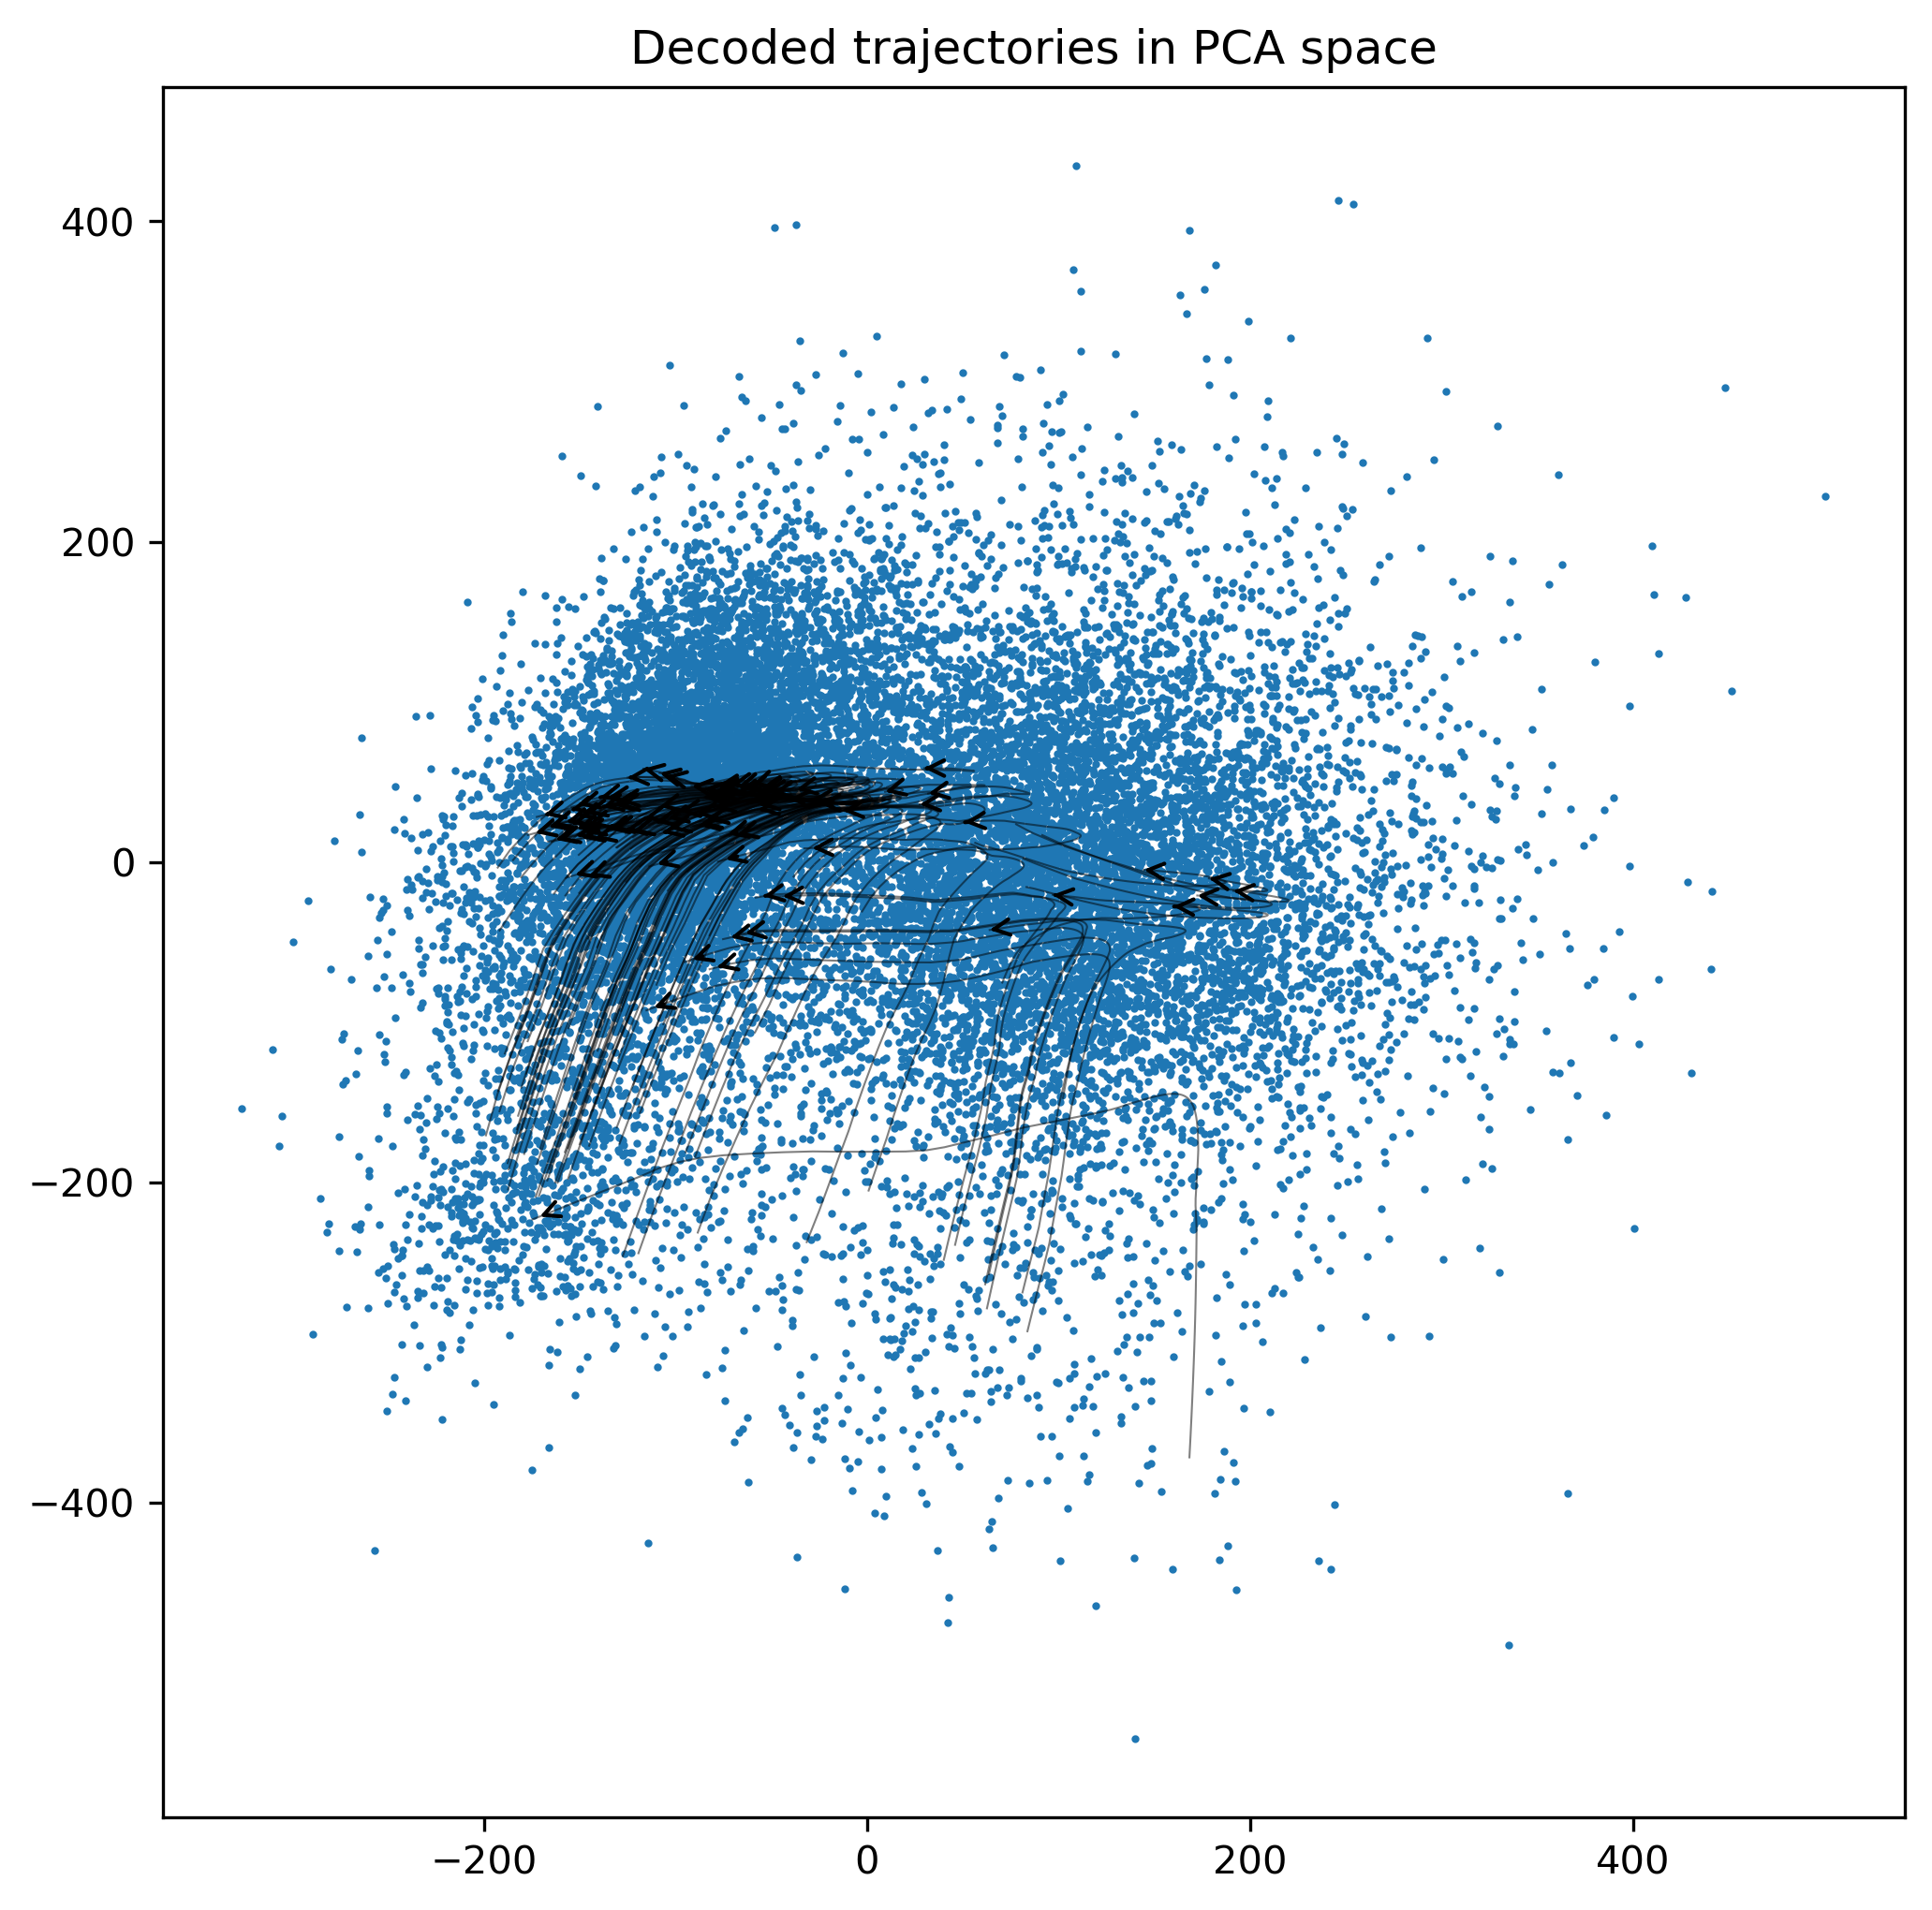

In [25]:
# THIS IS A SANITY CHECK TO VERIFY EVERY TRAJECTORY IS INSIDE THE MANIFOLD
# IF THEY ARE NOT WE CAN JUST DROP SPECIFIC TRAJECTORIES

fig = plt.figure(figsize=(8, 8), dpi=300)
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=1)

for i,trajectory_i in enumerate(np.transpose(traj_pca, axes=(1,0,2))):
    plt.plot(trajectory_i[:, 0], trajectory_i[:, 1], alpha=.5, linewidth=.5, c='Black')
    plt.annotate('', xy=(trajectory_i[-1, 0], trajectory_i[-1, 1]), xytext=(trajectory_i[-2, 0], trajectory_i[-2, 1]),
                 arrowprops=dict(arrowstyle='->', color='Black', lw=1, mutation_scale=10))
plt.title("Decoded trajectories in PCA space")

## [Optional] Dropping weird trajectories
The trajectories have some randomness to them, but it is normal to have one that is an outlier.

Here we can just drop it based on the PCs

NOTE: ! You need to adjust this for your data !

In [ ]:
# Drop trajectories where the final point on the first principal component (PC1) exceeds 20
# You need to adjust this for your data!

# Remember, traj_pca is a 3D array with shape (n_time_points, n_trajectories, n_components)
outlier_indices = np.where(traj_pca[-1, :, 0] > 200)[0]

traj_pca = np.delete(traj_pca, outlier_indices, axis=1)
traj = np.delete(traj, outlier_indices, axis=1)

In [31]:
# Drop trajectories where the final point on the first principal component (PC1) exceeds 20
# You need to adjust this for your data!

# Remember, traj_pca is a 3D array with shape (n_time_points, n_trajectories, n_components)
outlier_indices = np.where(traj_pca[-1, :, 1] <-200)[0]

traj_pca = np.delete(traj_pca, outlier_indices, axis=1)
traj = np.delete(traj, outlier_indices, axis=1)

Verify if is was corrected

Text(0.5, 1.0, 'Decoded trajectories in PCA space')

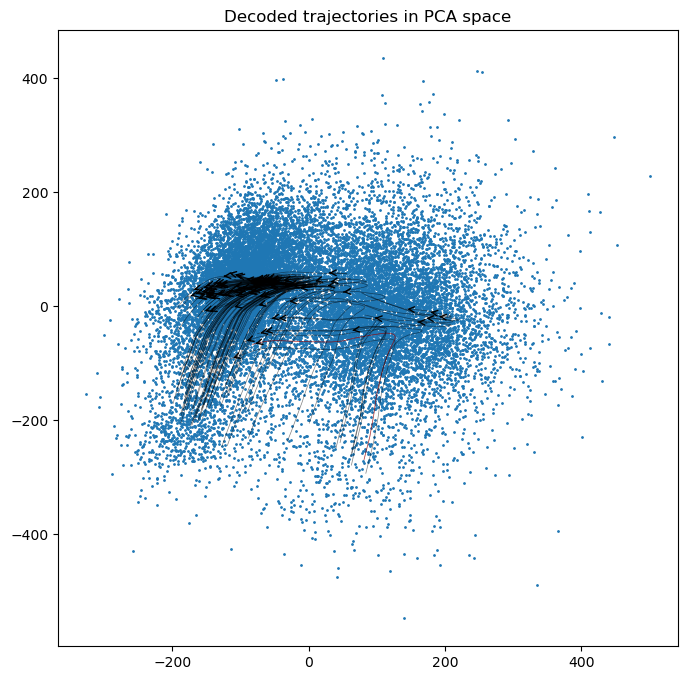

In [32]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=1)

for i,traji in enumerate(np.transpose(traj_pca, axes=(1,0,2))):
    plt.plot(traji[:, 0], traji[:, 1], alpha=.5, linewidth=.5, c='Black')
    if i == 5:
        plt.plot(traji[:, 0], traji[:, 1], alpha=.5, linewidth=.5, c='Red')
    plt.annotate('', xy=(traji[-1, 0], traji[-1, 1]), xytext=(traji[-2, 0], traji[-2, 1]),
                 arrowprops=dict(arrowstyle='->', color='Black', lw=1, mutation_scale=10))
plt.title("Decoded trajectories in PCA space")

# Converting from PCA space into Gene Space

Here we need to convert each of the time points in our trajectory back to Gene Space.

To do so, we need to have the PCA's loadings saved. We made sure to save those in the adata.

To revert the PCA we:
- Take each point in PC space
- Multiply it by the transpose of the PCA loadings matrix
- Add the mean of the original data (which was subtracted during PCA)



In [33]:
# Here we compute the decoded trajectories in the original space
# traj_pca is a 3D array with shape (n_time_points, n_trajectories, n_components)
# We reshape it to have shape (n_time_points * n_trajectories, n_components)

trajectories_all_points = traj_pca.reshape(-1, traj_pca.shape[-1])
X_reconstructed = np.array((trajectories_all_points @ adata.varm['PCs'].T) + adata.X.mean(axis=0))

#X_reconstructed have every point in our trajectory back in gene space
X_reconstructed.shape

(9700, 60)

In [34]:
trajectories_gene_space = X_reconstructed.reshape(traj.shape[0], traj.shape[1], -1)

In [35]:
trajectories_gene_space.shape

(100, 97, 60)

In [36]:
np.save(os.path.join(SAVE_PATH,'trajectories_gene_space.npy'), trajectories_gene_space)

# Observing the decoded genes
## Let's analyse the gene space

In [46]:
adata.var_names

Index(['CellBody_Intensity_UpperQuartileIntensity_Cycle01_CyclinB1',
       'CellBody_Intensity_UpperQuartileIntensity_Cycle01_DAPI',
       'CellBody_Intensity_UpperQuartileIntensity_Cycle01_Ecadherin',
       'CellBody_Intensity_UpperQuartileIntensity_Cycle01_p16INK2a',
       'CellBody_Intensity_UpperQuartileIntensity_Cycle02_EpCAM',
       'CellBody_Intensity_UpperQuartileIntensity_Cycle02_TJP1',
       'CellBody_Intensity_UpperQuartileIntensity_Cycle02_ZEB1',
       'CellBody_Intensity_UpperQuartileIntensity_Cycle03_CyclinA1A2',
       'CellBody_Intensity_UpperQuartileIntensity_Cycle03_cMyc',
       'CellBody_Intensity_UpperQuartileIntensity_Cycle03_pSMAD23',
       'CellBody_Intensity_UpperQuartileIntensity_Cycle04_CyclinE1',
       'CellBody_Intensity_UpperQuartileIntensity_Cycle04_NCADHERIN',
       'CellBody_Intensity_UpperQuartileIntensity_Cycle04_TWIST',
       'CellBody_Intensity_UpperQuartileIntensity_Cycle05_CD44',
       'CellBody_Intensity_UpperQuartileIntensity_Cycle05

In [49]:
gene_markers = [
    'CellBody_Intensity_UpperQuartileIntensity_Cycle01_CyclinB1',
    'CellBody_Intensity_UpperQuartileIntensity_Cycle14_CyclinD1',
    'CellBody_Intensity_UpperQuartileIntensity_Cycle14_pRB',
    'CellBody_Intensity_UpperQuartileIntensity_Cycle10_p21Waf1Cip1',
    'CellBody_Intensity_UpperQuartileIntensity_Cycle02_ZEB1',
    'CellBody_Intensity_UpperQuartileIntensity_Cycle06_Ki67',
    'CellBody_Intensity_UpperQuartileIntensity_Cycle11_P53',
    'CellBody_Intensity_UpperQuartileIntensity_Cycle02_EpCAM'
]

example_gene = gene_markers
example_gene = [g for g in example_gene if g in adata.var_names]
example_gene_mask = adata.var_names.isin(example_gene)

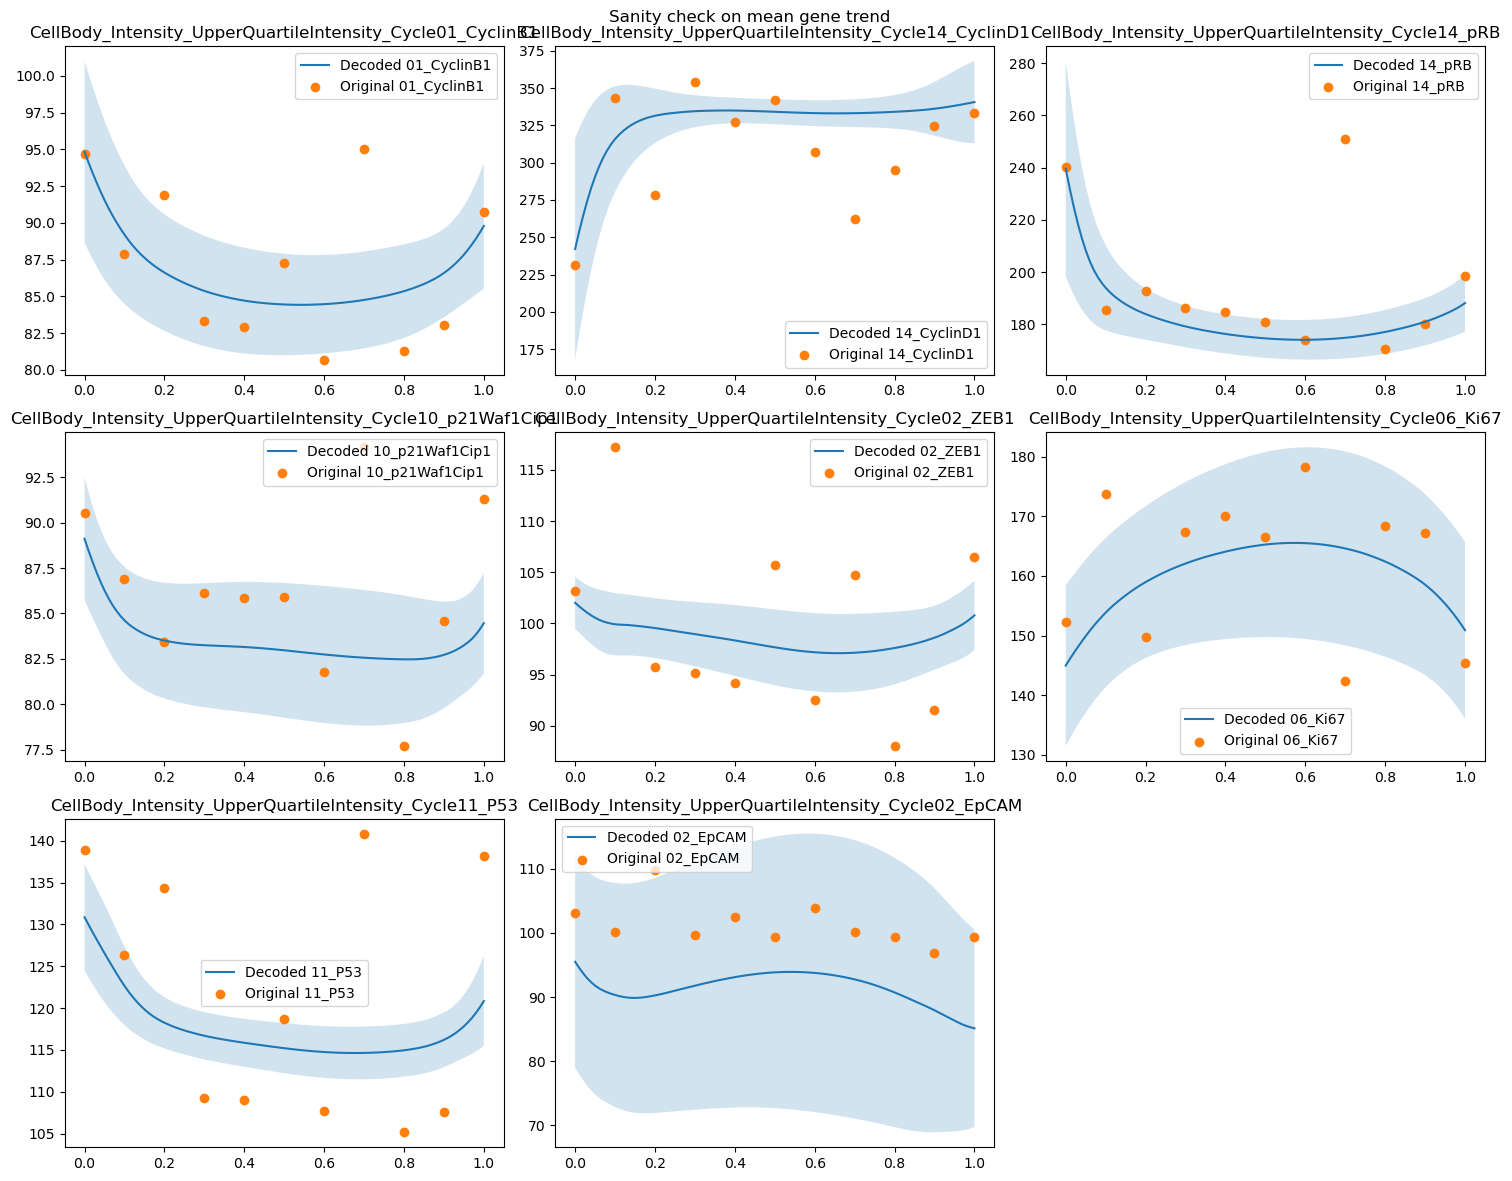

In [50]:
#TODO: Visualizing the decoded gene expression compared against the decoded back PCA (this should be the first plot)
X_pca_dec_back = (X_pca @ adata.varm['PCs'].T) + adata.X.mean(axis=0)

adata_example_gene = adata[:, example_gene_mask]
decoded_example_gene = trajectories_gene_space[:, :, example_gene_mask]
decoded_example_gene_mean = decoded_example_gene.mean(axis=1)
decoded_example_gene_std = decoded_example_gene.std(axis=1)
x_time = np.linspace(0, 1, traj.shape[0])
x_time_data = adata_example_gene.obs['discrete_time']
x_time_data = (x_time_data - x_time_data.min()) / (x_time_data.max() - x_time_data.min())

# data_df = pd.DataFrame(adata_example_gene.X.toarray(), columns=example_gene, index=adata_example_gene.obs_names)
data_df = pd.DataFrame(X_pca_dec_back[:, example_gene_mask], columns=example_gene, index=adata_example_gene.obs_names)
data_df['x_time'] = x_time_data

data_mean = data_df.groupby('x_time').mean()
data_std = data_df.groupby('x_time').std()

n_genes = decoded_example_gene_mean.shape[1]
n_rows = int(np.ceil(np.sqrt(n_genes)))
n_cols = int(np.ceil(n_genes / n_rows))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for i in range(n_genes):
    ax = axes[i]
    ax.plot(x_time, decoded_example_gene_mean[:,i], label=f'Decoded {example_gene[i].split("_Cycle")[-1]}')
    ax.fill_between(x_time, decoded_example_gene_mean[:,i] - decoded_example_gene_std[:,i], decoded_example_gene_mean[:,i] + decoded_example_gene_std[:,i], alpha=0.2)
    ax.scatter(data_mean.index, data_mean[example_gene[i]], label=f'Original {example_gene[i].split("_Cycle")[-1]}')
    # ax.fill_between(data_mean.index, data_mean[example_gene[i]] - data_std[example_gene[i]], data_mean[example_gene[i]] + data_std[example_gene[i]], alpha=0.2)
    ax.legend()
    ax.set_title(example_gene[i])
    
# Hide empty subplots
for i in range(n_genes, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
# Add suptitle with padding
plt.subplots_adjust(top=0.95)  # Leave space at top
plt.suptitle('Sanity check on mean gene trend', y=0.98)  # Position suptitle in the space

plt.show()

## Using MAGIC to denoise the measurements and sanity check the conclusions

In [51]:
import magic

In [52]:
magic_op = magic.MAGIC(random_state=42, n_jobs=-1)
magic_op.fit(adata.obsm['X_pca'])
X_magic = magic_op.transform(adata[:, example_gene_mask].X)

Running MAGIC on 19400 cells and 50 genes.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 5.68 seconds.
  Calculating affinities...
  Calculated affinities in 5.64 seconds.
Calculated graph and diffusion operator in 11.33 seconds.
Calculating imputation...


/Users/joaofelipe/miniconda3/envs/omics_toolbox/lib/python3.10/site-packages/magic/magic.py:541: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  warnings.warn(


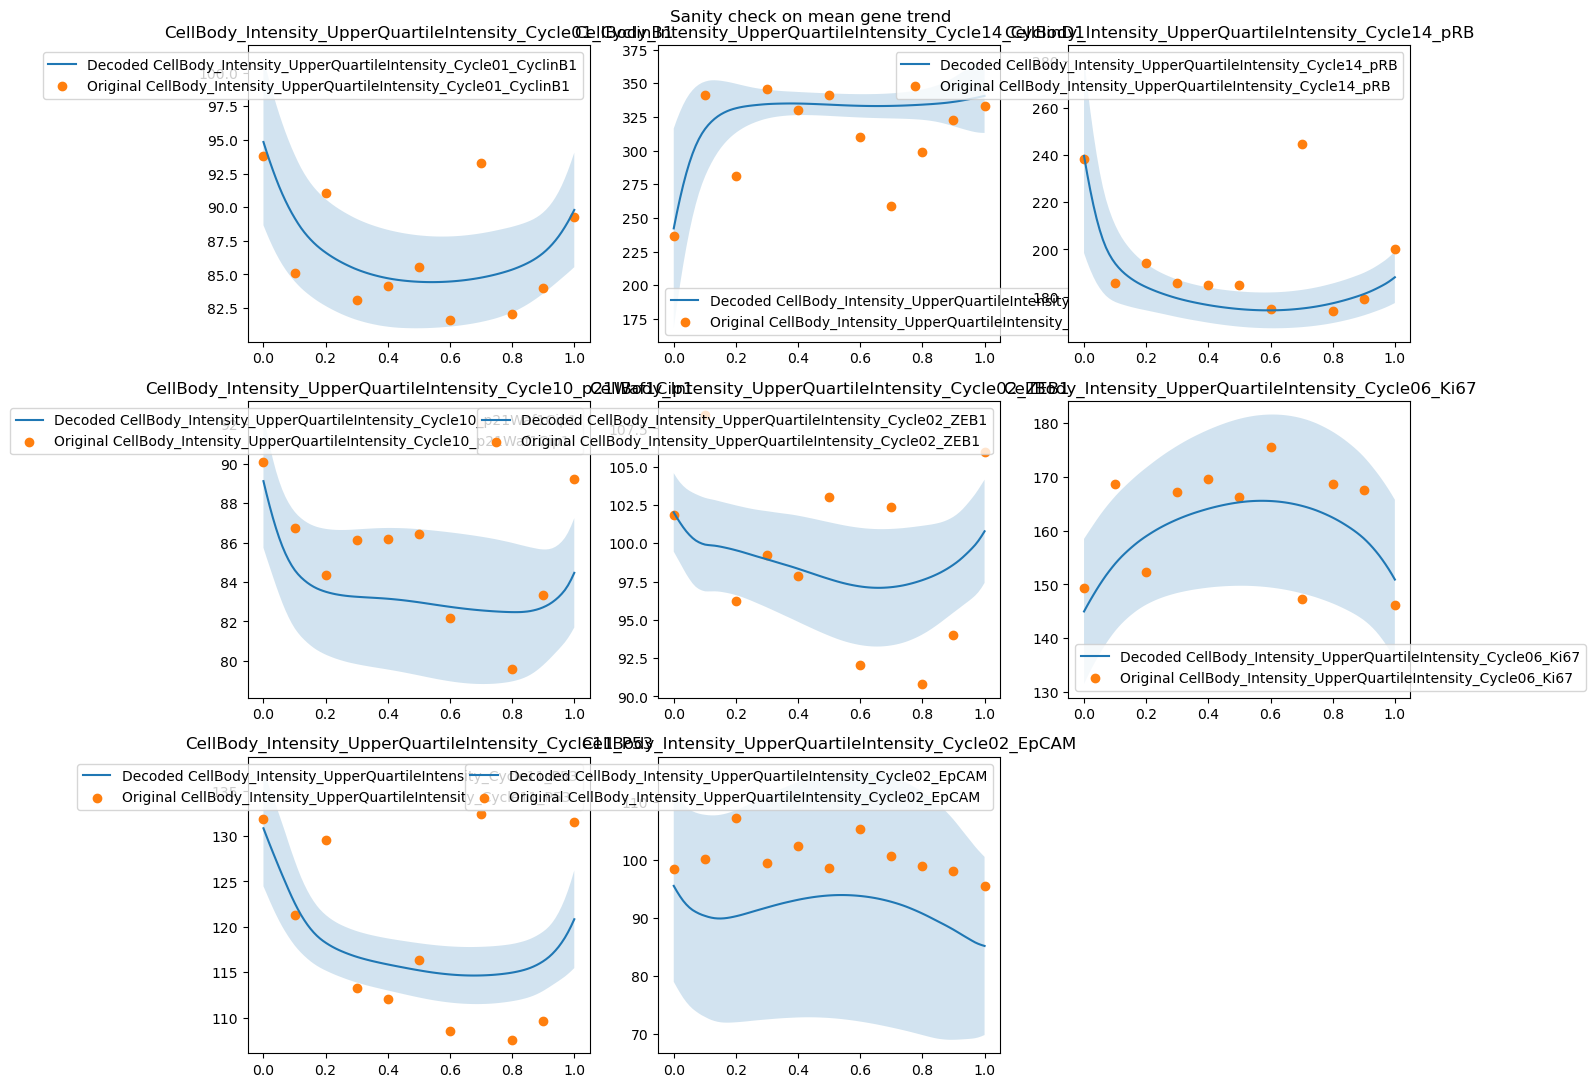

In [55]:
# Comparing MIOFLOW TRAJECTORIES with MAGIC denoised genes to be extra sure

adata_example_gene = adata[:, example_gene_mask]
decoded_example_gene = trajectories_gene_space[:, :, example_gene_mask]
decoded_example_gene_mean = decoded_example_gene.mean(axis=1)
decoded_example_gene_std = decoded_example_gene.std(axis=1)

x_time = np.linspace(0, 1, traj.shape[0])

x_time_data = adata_example_gene.obs['discrete_time']
x_time_data = (x_time_data - x_time_data.min()) / (x_time_data.max() - x_time_data.min())

data_df = pd.DataFrame(X_magic, columns=example_gene, index=adata_example_gene.obs_names)
data_df['x_time'] = x_time_data

data_mean = data_df.groupby('x_time').mean()
data_std = data_df.groupby('x_time').std()

n_genes = decoded_example_gene_mean.shape[1]
n_rows = int(np.ceil(np.sqrt(n_genes)))
n_cols = int(np.ceil(n_genes / n_rows))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for i in range(n_genes):
    ax = axes[i]
    ax.plot(x_time, decoded_example_gene_mean[:,i], label=f'Decoded {example_gene[i]}')
    ax.fill_between(x_time, decoded_example_gene_mean[:,i] - decoded_example_gene_std[:,i], decoded_example_gene_mean[:,i] + decoded_example_gene_std[:,i], alpha=0.2)
    ax.scatter(data_mean.index, data_mean[example_gene[i]], label=f'Original {example_gene[i]}')
    # ax.fill_between(data_mean.index, data_mean[example_gene[i]] - data_std[example_gene[i]], data_mean[example_gene[i]] + data_std[example_gene[i]], alpha=0.2)
    ax.legend()
    ax.set_title(example_gene[i])
    
# Hide empty subplots
for i in range(n_genes, len(axes)):
    axes[i].set_visible(False)

# plt.tight_layout()
# Add suptitle with padding
plt.subplots_adjust(top=0.95)  # Leave space at top
plt.suptitle('Sanity check on mean gene trend', y=0.98)  # Position suptitle in the space

plt.show()